In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import torch
import torch.nn.functional as F
from sklearn.covariance import LedoitWolf
import torchvision.models as models
from sklearn.neighbors import NearestNeighbors
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

In [18]:
trainSize = 5000
bs = 64

In [19]:
def get_data(digits, oodDigit):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),    
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    transformC = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),    
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformC)
    
    train = torch.tensor([1 if data.targets[i] in digits  else 0 for i in range(len(data))])
    data = torch.utils.data.Subset(data, train.nonzero())

    testIn = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformC)
    
    test = torch.tensor([1 if testIn.targets[i] in digits  else 0 for i in range(len(testIn))])
    testIn = torch.utils.data.Subset(testIn, test.nonzero())

    testOut = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformC)
    
    test = torch.tensor([1 if testOut.targets[i] in [oodDigit]  else 0 for i in range(len(testOut))])
    testOut = torch.utils.data.Subset(testOut, test.nonzero())
    
    OOD = datasets.MNIST(root = './data', train = False, transform = transform, download = True)
    OOD2 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transformC)
    OOD3 = datasets.SVHN(root = './data', split='test', transform = transformC, download = True)

    data, _ = torch.utils.data.random_split(data, [trainSize, len(data)-trainSize])
    testIn, _ = torch.utils.data.random_split(testIn, [300, len(testIn)-300])
    testOut, _ = torch.utils.data.random_split(testOut, [300, len(testOut)-300])
    OOD, _ = torch.utils.data.random_split(OOD, [300, len(OOD)-300])
    OOD2, _ = torch.utils.data.random_split(OOD2, [300, len(OOD2)-300])
    OOD3, _ = torch.utils.data.random_split(OOD3, [300, len(OOD3)-300])

    return data, testIn, testOut, OOD, OOD2, OOD3

In [20]:
@torch.no_grad()
def get_latent_vectors(model, train_loader, device):
    model.eval()

    latent_vectors = {}
    for cnt, x in enumerate(train_loader):
        x = x[0].to(device) # Move the minibatch to gpu
        features = model(x)

        for i in range(len(features)):
            if cnt == 0:
                latent_vectors[str(i)] = []    

            latent_vectors[str(i)].append(features[i].mean(dim=(2,3)))

    # Concatenate all vectors
    for i in range(len(features)):
        latent_vectors[str(i)] = torch.cat(latent_vectors[str(i)]).cpu().numpy()

    return latent_vectors

In [21]:
# Adapted from https://github.com/ORippler/gaussian-ad-mvtec
class ResNet_features(nn.Module):
    def __init__(
        self,
        resnet: nn.Module,
    ):
        super().__init__()
        self.conv1 = resnet.conv1

        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x0 = self.maxpool(x)

        result = []
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        for i in [0, 1, 2, 3, 4]:
            result.append(locals()["x" + str(i)])

        return result

In [22]:
def get_features(data, testIn, testOut, OOD, OOD2, OOD3, digits):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    network = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
    network = ResNet_features(network)

    network = nn.DataParallel(network)

    network.to(device)
    network.eval()

    trainLoader = torch.utils.data.DataLoader(data, batch_size=bs, shuffle=False, num_workers=4)
    trainFeatures = get_latent_vectors(network, trainLoader, device)

    inLoader = torch.utils.data.DataLoader(testIn, batch_size=bs, shuffle=False, num_workers=4)
    inFeatures = get_latent_vectors(network, inLoader, device)

    outLoader = torch.utils.data.DataLoader(testOut, batch_size=bs, shuffle=False, num_workers=4)
    outFeatures = get_latent_vectors(network, outLoader, device)

    OODLoader = torch.utils.data.DataLoader(OOD, batch_size=bs, shuffle=False, num_workers=4)
    oodFeatures = get_latent_vectors(network, OODLoader, device)
    
    OOD2Loader = torch.utils.data.DataLoader(OOD2, batch_size=bs, shuffle=False, num_workers=4)
    ood2Features = get_latent_vectors(network, OOD2Loader, device)
    
    OOD3Loader = torch.utils.data.DataLoader(OOD3, batch_size=bs, shuffle=False, num_workers=4)
    ood3Features = get_latent_vectors(network, OOD3Loader, device)
    
    return trainFeatures, inFeatures, outFeatures, oodFeatures, ood2Features, ood3Features

In [23]:
def maha(train, points):
    train = np.array(train)
    mean = np.mean(train, axis=0)

    LW = LedoitWolf().fit(train)
    covI = np.linalg.inv(LW.covariance_)
    
    points = (points - mean)[:, None]
    dists = covI @ points.transpose(0, 2, 1)
    dists = points @ dists
    dists = np.sqrt(dists[:, 0, 0])    
    return dists

In [24]:
def get_scores(trainFeatures, features):
    scores = np.zeros(features[str(0)].shape[0])

    for layer in range(5):
        dists = maha(trainFeatures[str(layer)], features[str(layer)])
        scores += dists
        
    return scores

In [25]:
def get_scores_knn(trainFeatures, features):
    model = NearestNeighbors(n_neighbors=2)

    model.fit(trainFeatures['4'])
    dists = np.mean(model.kneighbors(features['4'])[0], axis=1)
        
    return dists

In [26]:
def auc(scoresIn, scoresOut):
    groundTruthIn = np.array([1 for i in range(len(scoresIn))])
    groundTruthOut = np.array([-1 for i in range(len(scoresOut))])

    groundTruth = np.append(groundTruthIn, groundTruthOut)

    scores = np.append(scoresIn, scoresOut)

    auroc = roc_auc_score(groundTruth, scores)
    
    return auroc

In [27]:
mahascores = {}
dn2scores = {}

In [29]:
digits = []
outscores = []
oodscores = []
ood2scores = []
ood3scores = []

outscores_knn = []
oodscores_knn = []
ood2scores_knn = []
ood3scores_knn = []

for i in range(9):
    digits.append(1+i)
    
    data, testIn, testOut, OOD, OOD2, OOD3 = get_data(digits, 0)
    trainFeatures, inFeatures, outFeatures, oodFeatures, ood2Features, ood3Features = \
        get_features(data, testIn, testOut, OOD, OOD2, OOD3, digits)

    inScores = get_scores(trainFeatures, inFeatures)
    outScores = get_scores(trainFeatures, outFeatures)
    oodScores = get_scores(trainFeatures, oodFeatures)
    ood2Scores = get_scores(trainFeatures, ood2Features)
    ood3Scores = get_scores(trainFeatures, ood3Features)

    outscores.append(auc(-1*inScores, -1*outScores))
    oodscores.append(auc(-1*inScores, -1*oodScores))
    ood2scores.append(auc(-1*inScores, -1*ood2Scores))
    ood3scores.append(auc(-1*inScores, -1*ood3Scores))
    
    inScores = get_scores_knn(trainFeatures, inFeatures)
    outScores = get_scores_knn(trainFeatures, outFeatures)
    oodScores = get_scores_knn(trainFeatures, oodFeatures)
    ood2Scores = get_scores_knn(trainFeatures, ood2Features)
    ood3Scores = get_scores_knn(trainFeatures, ood3Features)

    outscores_knn.append(auc(-1*inScores, -1*outScores))
    oodscores_knn.append(auc(-1*inScores, -1*oodScores))
    ood2scores_knn.append(auc(-1*inScores, -1*ood2Scores))
    ood3scores_knn.append(auc(-1*inScores, -1*ood3Scores))

mahascores['held'] = outscores
mahascores['ood'] = oodscores
mahascores['ood2'] = ood2scores
mahascores['ood3'] = ood3scores

dn2scores['held'] = outscores_knn
dn2scores['ood'] = oodscores_knn
dn2scores['ood2'] = ood2scores_knn
dn2scores['ood3'] = ood3scores_knn

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


Using cache found in /home/lars/.cache/torch/hub/pytorch_vision_v0.6.0


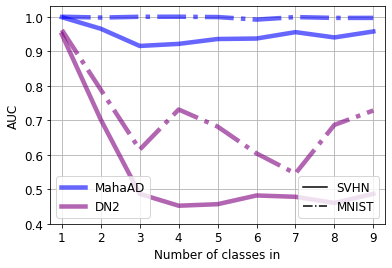

In [30]:
plt.rcParams.update({'font.size': 12})

plt.figure()
labels = ['MahaAD', 'DN2', 'MSCL']
colors = ['b', 'purple', 'orange']
# for idx, method in enumerate([mahascores, dn2scores, msclscores]):
for idx, method in enumerate([mahascores, dn2scores]):
    plt.plot(np.arange(len(method['ood'])) + 1, method['ood'], colors[idx], linestyle='-.', linewidth=4.5, alpha=0.6)
    plt.plot(np.arange(len(method['ood3'])) + 1, method['ood3'], colors[idx], linewidth=4.5, label=labels[idx], alpha=0.6)

plot_lines = []
l, = plt.plot([-1], '-', color='black')
l2, = plt.plot([-1], '-.', color='black')
plot_lines.append([l, l2])
legend1 = plt.legend(plot_lines[0], ["SVHN", 'MNIST'], loc=4)
plt.gca().add_artist(legend1)

plt.xlabel('Number of classes in')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.ylim(0.4, 1.03)
plt.xlim(0.7, 9.3)
plt.show()
plt.close()

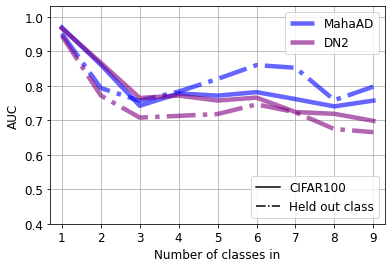

In [31]:
plt.figure()
labels = ['MahaAD', 'DN2', 'MSCL']
colors = ['b', 'purple', 'orange']
for idx, method in enumerate([mahascores, dn2scores]):
# for idx, method in enumerate([mahascores, dn2scores, msclscores]):
    plt.plot(np.arange(len(method['held'])) + 1, method['held'], colors[idx], linestyle='-.', label=labels[idx], linewidth=4.5, alpha=0.6)
    plt.plot(np.arange(len(method['ood2'])) + 1, method['ood2'], colors[idx], linewidth=4.5, alpha=0.6)
    
plot_lines = []
l, = plt.plot([-1], '-', color='black')
l2, = plt.plot([-1], '-.', color='black')
plot_lines.append([l, l2])
legend1 = plt.legend(plot_lines[0], ['CIFAR100', "Held out class"], loc=4)
plt.gca().add_artist(legend1)

plt.xlabel('Number of classes in')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.ylim(0.4, 1.03)
plt.xlim(0.7, 9.3)
plt.show()
plt.close()